In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset Preparation

In [2]:
transform_mnist = transforms.Compose([
    transforms.ToTensor()
])

transform_cifar = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)
cifar_loader = torch.utils.data.DataLoader(cifar_dataset, batch_size=1, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 138862967.21it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 19022564.98it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 49326643.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3473204.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:01<00:00, 91943064.22it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


# 2. Mean Image Computation


In [3]:
# Randomly select one image from each dataset
mnist_image, _ = next(iter(mnist_loader))
cifar_image, _ = next(iter(cifar_loader))


# Resize the MNIST image to 32x32 pixels
mnist_image_resized = transforms.functional.resize(mnist_image, [32, 32])

# Extend the channels of the MNIST image to 3
mnist_image_extended = mnist_image_resized.repeat(1, 3, 1, 1)

mean_image = (mnist_image_extended + cifar_image) / 2

In [4]:
def show_image(img, title):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

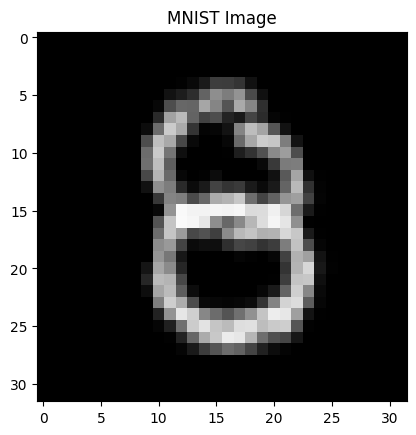

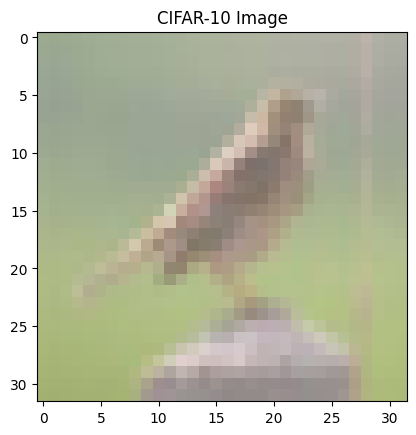

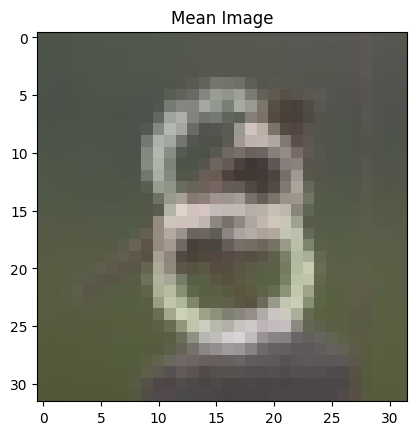

In [5]:
show_image(mnist_image_extended[0], 'MNIST Image')
show_image(cifar_image[0], 'CIFAR-10 Image')
show_image(mean_image[0], 'Mean Image')

# 4. Autoencoder Model Construction


In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x, z

In [7]:
# Instantiate the autoencoder
autoencoder = Autoencoder()

# 5. Model Training
# Use Mean Squared Error loss and Adam optimizer
reconstruction_loss = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder using the mean image
num_epochs = 10000
mean_image_input = mean_image.clone().detach()

In [8]:
for epoch in range(num_epochs):
    output, z = autoencoder(mean_image_input)

    # Calculate the reconstruction loss
    rec_loss = reconstruction_loss(output, mean_image_input)

    total_loss = rec_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], recuns Loss: {rec_loss:.4f}')

Epoch [100/10000], recuns Loss: 0.0064
Epoch [200/10000], recuns Loss: 0.0023
Epoch [300/10000], recuns Loss: 0.0014
Epoch [400/10000], recuns Loss: 0.0010
Epoch [500/10000], recuns Loss: 0.0008
Epoch [600/10000], recuns Loss: 0.0007
Epoch [700/10000], recuns Loss: 0.0006
Epoch [800/10000], recuns Loss: 0.0005
Epoch [900/10000], recuns Loss: 0.0005
Epoch [1000/10000], recuns Loss: 0.0004
Epoch [1100/10000], recuns Loss: 0.0004
Epoch [1200/10000], recuns Loss: 0.0003
Epoch [1300/10000], recuns Loss: 0.0003
Epoch [1400/10000], recuns Loss: 0.0003
Epoch [1500/10000], recuns Loss: 0.0002
Epoch [1600/10000], recuns Loss: 0.0002
Epoch [1700/10000], recuns Loss: 0.0002
Epoch [1800/10000], recuns Loss: 0.0002
Epoch [1900/10000], recuns Loss: 0.0002
Epoch [2000/10000], recuns Loss: 0.0001
Epoch [2100/10000], recuns Loss: 0.0001
Epoch [2200/10000], recuns Loss: 0.0001
Epoch [2300/10000], recuns Loss: 0.0001
Epoch [2400/10000], recuns Loss: 0.0001
Epoch [2500/10000], recuns Loss: 0.0001
Epoch [26

# 6. Reconstruction
### a. Input the mean image into the trained autoencoder
### b. Obtain reconstructions of both MNIST and CIFAR-10 images

In [9]:
with torch.no_grad():
    reconstructed_mean_image, _ = autoencoder(mean_image_input)


reconstructed_mnist_image= (reconstructed_mean_image * 2) - cifar_image
reconstructed_cifar_image= (reconstructed_mean_image * 2) - mnist_image_extended

# 7. Evaluation
### a. Assess the quality of reconstructions visually

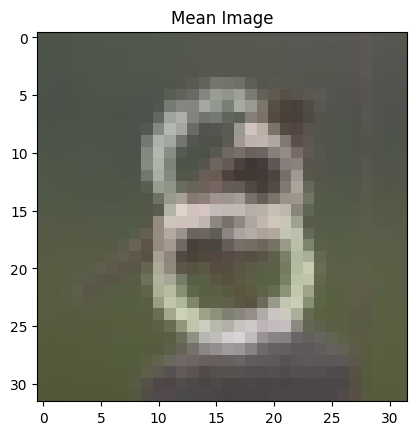

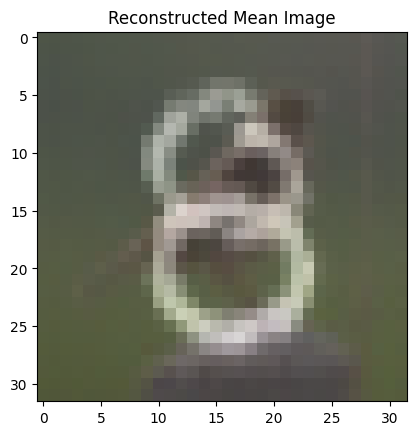

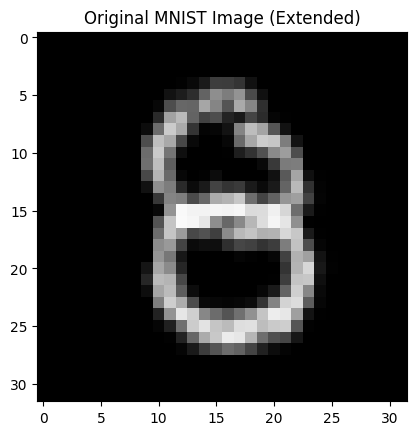

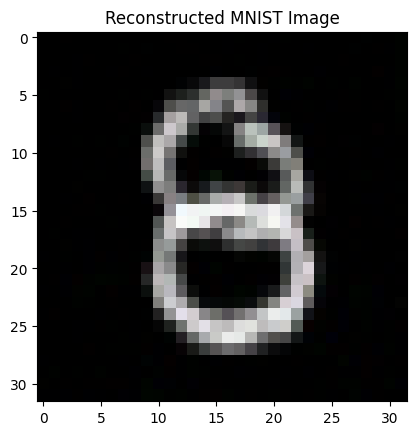

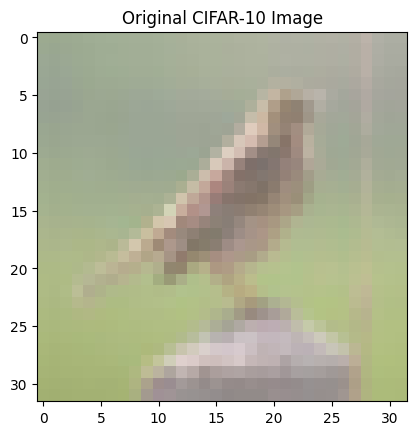

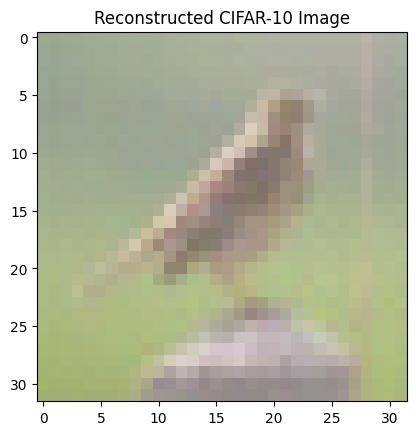

In [10]:
show_image(mean_image[0], 'Mean Image')
show_image(reconstructed_mean_image[0], 'Reconstructed Mean Image')
show_image(mnist_image_extended[0], 'Original MNIST Image (Extended)')
show_image(reconstructed_mnist_image[0], 'Reconstructed MNIST Image')
show_image(cifar_image[0], 'Original CIFAR-10 Image')
show_image(reconstructed_cifar_image[0], 'Reconstructed CIFAR-10 Image')

# b. Compare the reconstructed MNIST and CIFAR-10 images with their originals
### Using SSIM and PSNR for quantitative evaluation

In [11]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_metrics(original, reconstructed):
    original_np = original[0].numpy().transpose(1, 2, 0)
    reconstructed_np = reconstructed[0].detach().numpy().transpose(1, 2, 0)

    ssim_value = ssim(original_np, reconstructed_np, multichannel=True)
    psnr_value = psnr(original_np, reconstructed_np)

    return ssim_value, psnr_value

# MNIST Metrics
mnist_ssim, mnist_psnr = evaluate_metrics(mnist_image_extended, reconstructed_mnist_image)
print(f'MNIST SSIM: {mnist_ssim:.4f}, PSNR: {mnist_psnr:.4f}')

# CIFAR-10 Metrics
cifar_ssim, cifar_psnr = evaluate_metrics(cifar_image, reconstructed_cifar_image)
print(f'CIFAR-10 SSIM: {cifar_ssim:.4f}, PSNR: {cifar_psnr:.4f}')

MNIST SSIM: 0.9975, PSNR: 44.0286
CIFAR-10 SSIM: 0.9940, PSNR: 44.0286


<ipython-input-11-1c5556455a31>:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(original_np, reconstructed_np, multichannel=True)
